## Assigment of Alexis Rosenfeld and François Delafontaine

In [3]:
## Imports (for both tasks)

# Generics
import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Hyperparameter selection
from sklearn.neighbors import KNeighborsClassifier as sk_kNN
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.model_selection import train_test_split as sk_tts
# Feature selection
from sklearn.metrics import r2_score as sk_r2
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

## Task 1: **Combining Feature Selection Methods**

1. Generate the synthetic dataset of your project.

2. First, use the filter method (correlation-based) to remove irrelevant features.

3. Then, apply RFE to further eliminate any unnecessary features.

4. Finally, train a Random Forest model and use the feature importance scores to select the top features.

5. Compare and evaluate the model performance at each step when (using all features, after filtering, after RFE, after feature importance selection).

## 1. Generating the dataset

For each datapoint we need to generate a fake dataset (with 'genf_dataset()'), then estimate its 'k' hyperparameter value (using 'get_hp()') and finally derive our independent variables (using 'get_vi()').

We cheat for the independent values by retrieving most of them during the fake dataset generation ('d_vi'). Some are simply inaccessible otherwise -- an actual model could not rely on those, hence the random generation in absence of 'd_vi'.

We save our model's dataset as a CSV so as to not re-generate the fake datasets each time. 'genf_dataset()' is set to load that file if provided the path (instead of the number of datapoints).

Our model's dataset is stored as a numpy.array in 'model_data', and as a dataframe in 'df'.

In [4]:
def plot_dataset(dataset, cx=None):
    """Shows the 'x' values of fake dataset as scatterplots."""
    fig, ax = plt.subplots(1, 2)
    n_rows, n_cols = dataset.shape
    lx = np.arange(1, n_rows+1, 1) # x-axis (row-index)
    for i in range(1, n_cols):     # y-axis (x-value)
        alpha = 0.7 if not cx else 0.4 if cx[i-1] == 0 else 0.8
        ax[0].scatter(lx, dataset[:,i], alpha=alpha)
        alpha = 0.7 if not cx else 0.1 if cx[i-1] == 0 else 0.8
        ax[1].scatter(dataset[:,i], dataset[:,0], alpha=alpha)
    ax[0].set_xlabel("Row index")
    ax[0].set_ylabel("X-value")
    ax[1].set_xlabel("X-value")
    ax[1].set_ylabel("Y-value")
    fig.tight_layout()
    plt.show()
def genf_dataset(view=False):
    """Generates a single fake dataset.
       'x' values in interval [0, 1000].
       'x' types are 'linear', 'quadratic' and 'partial'."""
    lds = random.randint(100, 10000) # nb of rows
    lyc = random.randint(3, 5)       # nb of 'y' classes
        # nb of 'x', non-random and distribution type
    cx, ixd = [], 0
    lx = random.randint(3, 9); lxd = random.randint(1, int(lx))
    cx, ix = [], 0
    for i in range(lx): # can produce pure noise
        c = random.randint(0, 1)
        if c == 1 and ix < lxd: # store distribution type
            cx.append(random.randint(1, 3)); ix += 1; continue
        cx.append(0)
    del lx; del lxd
    distr_noise = random.randint(1, 3) # value overlap (categorized)
        # dataset generation proper
    dataset = []
    for r in range(lds):
        y = random.randint(0, lyc-1) # 'y' value
        yr = (y+1)/(lyc+1)           # ratio for non-random
        noise = (lds/20)*distr_noise # terrible std estimation
        dataset.append([y])
        for c in cx:
            match c: # Python 3.10 feature... instead of function dict.
                case 0: # random distribution
                    x = random.randint(0, 1000)
                case 1: # linear distribution
                    x = np.random.normal(1000*yr, noise)
                case 2: # quadratic distribution
                    x = np.random.normal(1000*(yr**2), noise)
                case 3: # partial distribution
                    x = random.randint(0, 1000) if \
                        random.randint(0, 100) > 80 else \
                        np.random.normal(1000*yr, noise)
            x = 0 if x < 0 else 1000 if x > 1000 else x
            dataset[-1].append(x)
    d_vi = {
        'nb_row': lds/100, # ratio per 100 lines because reasons
        'nb_y_classes': lyc,
        'nb_x_vars': len(cx),
        'nb_x_nr': ix,
        'distr_typ': sum(cx)/ix if ix > 0 else 0,
        'distr_noise': distr_noise
    } # cheating to provide values for our model
    if view:
        plot_dataset(np.array(dataset), cx)
    return np.array(dataset), d_vi
def get_hp(dataset):
    """Runs a kNN to find the best 'k'.
       Note: k limited to [1, sqrt(y)]."""
    x, y = dataset[:,1:], dataset[:,0]
    x_tr, x_te, y_tr, y_te = sk_tts(x, y) # train/test
    rk, ra, ly = 0, -1., int(np.sqrt(len(y)))-1
    for k in np.arange(1, ly, 1):         # all possible k's
        m = sk_kNN(k)                     # kNN model
        m.fit(x_tr, y_tr)                 # fit on training data
        yp_te = m.predict(x_te)           # predict on test data
        a = sk_acc(y_te, yp_te)           # get accuracy score
        if a > ra:                        # pick best 'k'
            ra, rk = a, k
    return rk
def get_vi(dataset, d_vi={}):
    """Derives (or cheats) the independent variables."""
    header = ['nb_row', 'nb_y_classes', 'nb_x_vars',
              'nb_x_nr', 'distr_typ', 'distr_noise', 'mean_var']
    l_vi = []
    for k in header:
        if k in d_vi:
            l_vi.append(d_vi[k]); continue
        match k:
            case 'nb_row':
                l_vi.append(dataset.shape[0]/100) # scale down a tad...
            case 'nb_y_classes':
                l_vi.append(max(dataset[:,0])+1)
            case 'nb_x_vars':
                l_vi.append(dataset.shape[1]-1)
            case 'nb_x_nr': # should never run due to cheating anyway...
                nb_corr = 0
                for i in range(1, dataset.shape[1]):
                    nb_corr = nb_corr+1 if numpy.corrcoef(dataset[:,0],
                                           dataset[:,i])[0][0] > 0.2 else \
                              nb_corr
                l_vi.append(nb_corr)
            case 'distr_typ': # random if no cheating
                l_vi.append(np.random.uniform(1, 3))
            case 'distr_noise': # random if no cheating
                l_vi.append(random.randint(1, 3))
            case 'mean_var': # not... the most scientific...
                var = 0.
                for i in range(1, dataset.shape[1]):
                    var += np.var(dataset[:,i])
                l_vi.append(var/100000)
    return l_vi
def load_md(f):
    """Returns the numpy.array of our data."""
    if not os.path.isfile(f):
        return np.array([])
    ll_res = []
    with open(f, 'r', encoding="utf-8") as rf:
        rf.readline()
        for line in rf:
            line = line.strip("\n") # just in case...
            line = [float(l) for l in line.split(",")]
            ll_res.append(line)
    return np.array(ll_res)
def save_md(data, mode="w"):
    """Saves model data as CSV (avoids running 'get_hp()' nth time)."""
    header = ['y', 'nb_row', 'nb_y_classes', 'nb_x_vars',
              'nb_x_nr', 'distr_typ', 'distr_noise', 'mean_var']
    with open("model_data.csv", mode=mode, encoding="utf-8") as wf:
        if mode == "w":
            wf.write(",".join(header)+"\n")
        for r in range(data.shape[0]):
            txt = ""
            for c in range(len(data[r,:])):
                txt = txt+f"{data[r,c]},"
            txt = txt.strip(",")+"\n"; wf.write(txt)
def simulate(n=100, mode=""):
    """Returns a single numpy matrix for model training/testing."""
    if isinstance(n, str): # Why generate when data already exists.
        return load_md(n)
    data = []
    if mode == "w":
        save_md(np.array([]), mode)
    st = time.time()
    for i in range(n):
        dataset, d_vi = genf_dataset()
        data.append([get_hp(dataset)]+get_vi(dataset, d_vi))
        if mode:
            save_md(np.array([data[-1]]), "a")
        print(f"{time.time()-st:0.1f}s, {i+1}/{n}"); st = time.time()
    return np.array(data)

model_data = simulate("model_data.csv") # ~1h for 1000 datapoints
header = ['y', 'nb_row', 'nb_y_classes', 'nb_x_vars',
          'nb_x_nr', 'distr_typ', 'distr_noise', 'mean_var']
df = pd.DataFrame(model_data, columns=header)

## 2-4. Correlation, RFE and importance testing

This is basically copy-pasted from the course, turned into functions with 'verbose' to silence them for sub-task (1.5).

In [5]:
def corr_test(df, verbose=True):
    """Correlation test."""
    correl = df.corr()['y'].abs().sort_values(ascending=False)
    correl = correl.drop('y')
    correl = pd.DataFrame(np.array([list(correl.keys()), correl.values]).T,
                          columns=['feature', 'score'])
    correl = correl.astype({'score': 'float64'})
    if verbose:
        print(correl)
    return correl
def rfe_test(df, verbose=True):
    """RFE test."""
    X, y = df.drop(columns=['y']), df['y']
    rfe = RFE(LinearRegression(), n_features_to_select=int(X.shape[1]/2))
    rfe.fit(X, y)
    rank = pd.DataFrame({
        'feature': X.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    if verbose:
        print(rank)
    return rank
def embed_test(df, verbose=True):
    """RandomForest 'importances' test."""
    X, y = df.drop(columns=['y']), df['y']
    m = RandomForestClassifier(); m.fit(X, y)
    rank = pd.DataFrame({
        'feature': X.columns,
        'importance': m.feature_importances_
    }).sort_values(by='importance', ascending=False)
    if verbose:
        print(rank)
    return rank

def test(df):
    """Test all three methods."""
    # We could turn this into a single table...
    print("\n\nCORREL")
    corr_test(df)
    print("\n\nRFE")
    rfe_test(df)
    print("\n\nRandomForest")
    embed_test(df)

## 5. Evaluating

We evaluate each (sub-)model independently, meaning that we derive m2-m4 from m1 only. As the training/accuracy_score part is the same, it is put in a separate function '_eval()'. 

Due to our model being a linear regression, scikit-learn did not appreciate us using a classification measure, so we reverted to R2 ('r2_score' as 'sk_r2()'). 

Note (Delafontaine): I would tend to avoid RFE as it seems that we pre-determine how many features ('x' variables) we want to keep, whereas others seem more based on a score threshold that, while also arbitrary, will return a varying amount of variables.

In [6]:
def _eval(X_tr, X_te, y_tr, y_te, feat):
    """Train model with only 'feat' features, return accuracy."""
    Xn_tr, Xn_te = X_tr[feat], X_te[feat]
    m = LinearRegression(); m.fit(Xn_tr, y_tr)
    yp = m.predict(Xn_te)
    return sk_r2(y_te, yp)
def evaluate(df):
    """Apply previous methods and check model accuracy_score."""
    X, y = df.drop(columns=['y']), df['y']
    X_tr, X_te, y_tr, y_te = sk_tts(X, y, test_size=0.3)
    m1 = LinearRegression()         # full model accuracy
    m1.fit(X_tr, y_tr); y1 = m1.predict(X_te)
    acc1 = sk_r2(y_te, y1) # 0.56
    
    r2 = corr_test(df, False)       # correlation model accuracy
    feat = r2[r2['score'] > 0.3]['feature']
    print("Correl-features:", feat.values)
    acc2 = _eval(X_tr, X_te, y_tr, y_te, feat) # 0.54
    
    r3 = rfe_test(df, False)        # RFE model accuracy
    feat = r3[r3['rank'] == 1]['feature'] # pick based on rank
    print("RFE-features", feat.values)
    acc3 = _eval(X_tr, X_te, y_tr, y_te, feat) # 0.34
    
    r4 = embed_test(df, False)      # importance model accuracy
    feat = r4[r4['importance'] > 0.15]['feature'] # pick based on score?
    print("Importance-features", feat.values)
    acc4 = _eval(X_tr, X_te, y_tr, y_te, feat) # 0.54
    
    print(f"m1: {acc1:.02f}, m2: {acc2:.02f}, m3: {acc3:.02f}, "
          f"m4: {acc4:.02f}")

evaluate(df)

Correl-features: ['nb_row' 'mean_var']
RFE-features ['nb_x_vars' 'distr_noise' 'mean_var']
Importance-features ['nb_row' 'mean_var']
m1: 0.50, m2: 0.50, m3: 0.26, m4: 0.50


Notes:

* The accuracy founds varies depending on the random shuffle from train_test_split (sk_tts) (we haven't set a seed at the start).
* The full model seems to perform just as well as with filtered features. This... is not good...
* RFE constantly performs worse by selecting the wrong variables, namely by discarding the number of rows.
* Surprisingly, all models believe that the mean variance (sum(np.var(x)) scaled) is predictive.
* Conversely, the type of distribution is discarded (fair, given the clumsy way we set it up here), as is the noise (suggesting it needs to be refined).



## Task 2: **Visualizing Feature Selection**

1. Use the synthetic dataset you generates in task 1.

2. Apply any feature selection technique (e.g., correlation-based, RFE, or Random Forest importance).

3. Plot the accuracy of the model with the different numbers of features selected (Create a plot showing the accuracy vs. the number of features used).

4. Use bar plots to show how the importance of features changes during the selection process.

5. Observe and analyze how feature selection impacts the performance visually

## 1-3. Plotting accuracy

Given the results in (1.5), correlation filtering should be preferred. Still, since each method orders the independent variables differently, a comparison is still interesting.

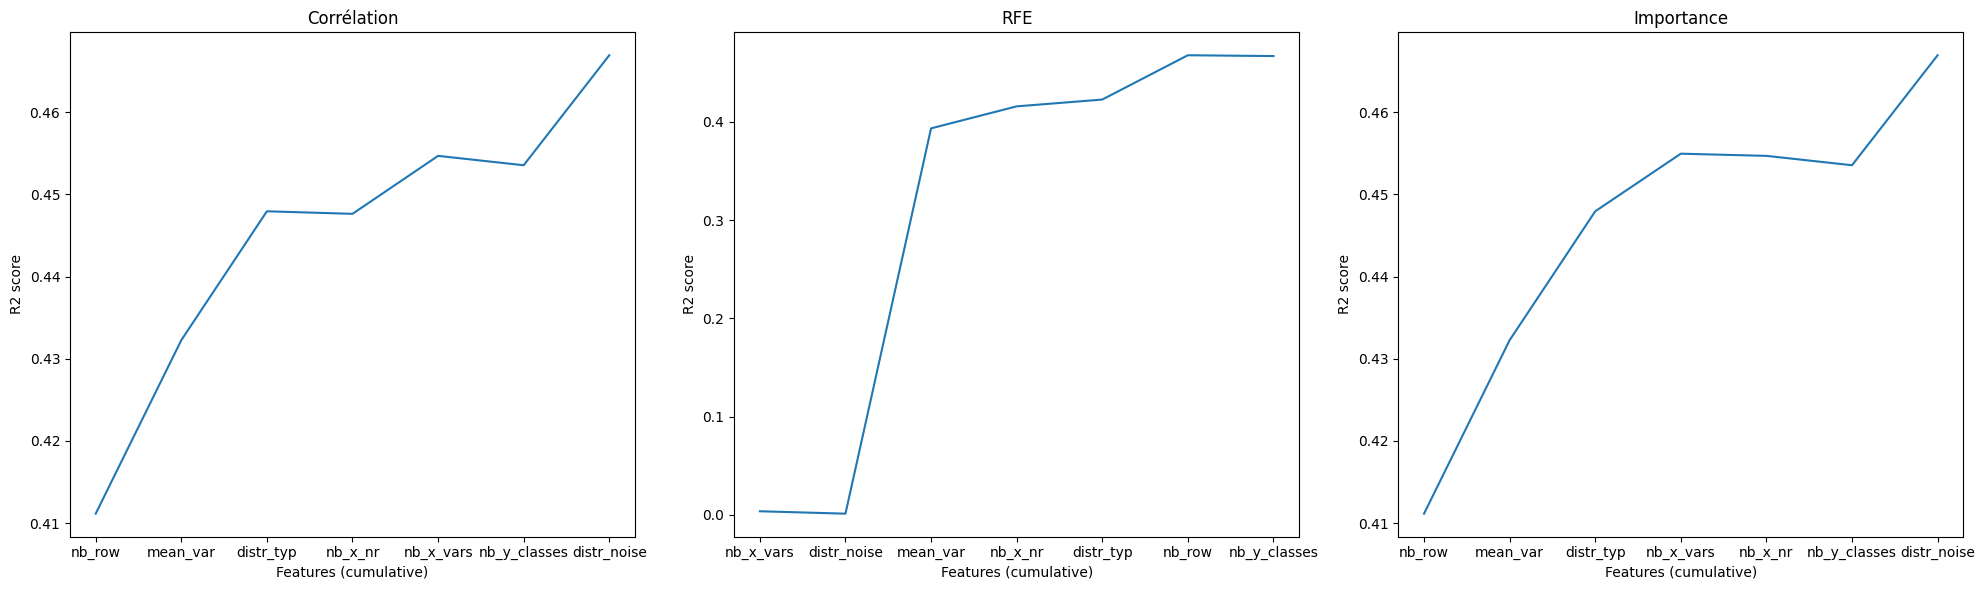

In [7]:
def plot_r2(df, plt_typ="plot"):
    """Using correlation filtering, plotting accuracy."""
    X, y = df.drop(columns=['y']), df['y']
    X_tr, X_te, y_tr, y_te = sk_tts(X, y, test_size=0.3)
    
    fig, ax = plt.subplots(1, 3, figsize=(20,6))
    l_titles = ["Corrélation", "RFE", "Importance"]
    for n, meth in enumerate([corr_test, rfe_test, embed_test]):
        r2 = meth(df, False)
        l_acc, feat = [], r2['feature']
        for i in range(1, len(feat)+1):
            l_acc.append(_eval(X_tr, X_te, y_tr, y_te, feat[:i]))
        if plt_typ == "plot":
            ax[n].plot(feat, l_acc)
        elif plt_typ == "bar":
            ax[n].bar(feat, l_acc)
        ax[n].set_xlabel("Features (cumulative)")
        ax[n].set_ylabel("R2 score")
        if n != 1 and plt_typ == "bar": # scale graph
            mi, ma = min(l_acc)-0.02, max(l_acc)+0.02
            ax[n].set_ylim([mi, ma])
        ax[n].set_title(l_titles[n])
    fig.tight_layout()
    plt.show()

plot_r2(df)

We can see more clearly the effect of 'nb_row' and 'mean_var' on the R2 score. 

More generally, the result can be non-monotonic, that is, the score can fall with more features depending on their order. Likewise, it may show the limits of those methods as we would otherwise expect a more... logarithmic shape, with a high slope early on and plateauing fairly quickly as the least impactful features would be in the long tail.

This is not what we observe and it likely has to do with our choice, and construct, of variables. 

## 4. Barplots

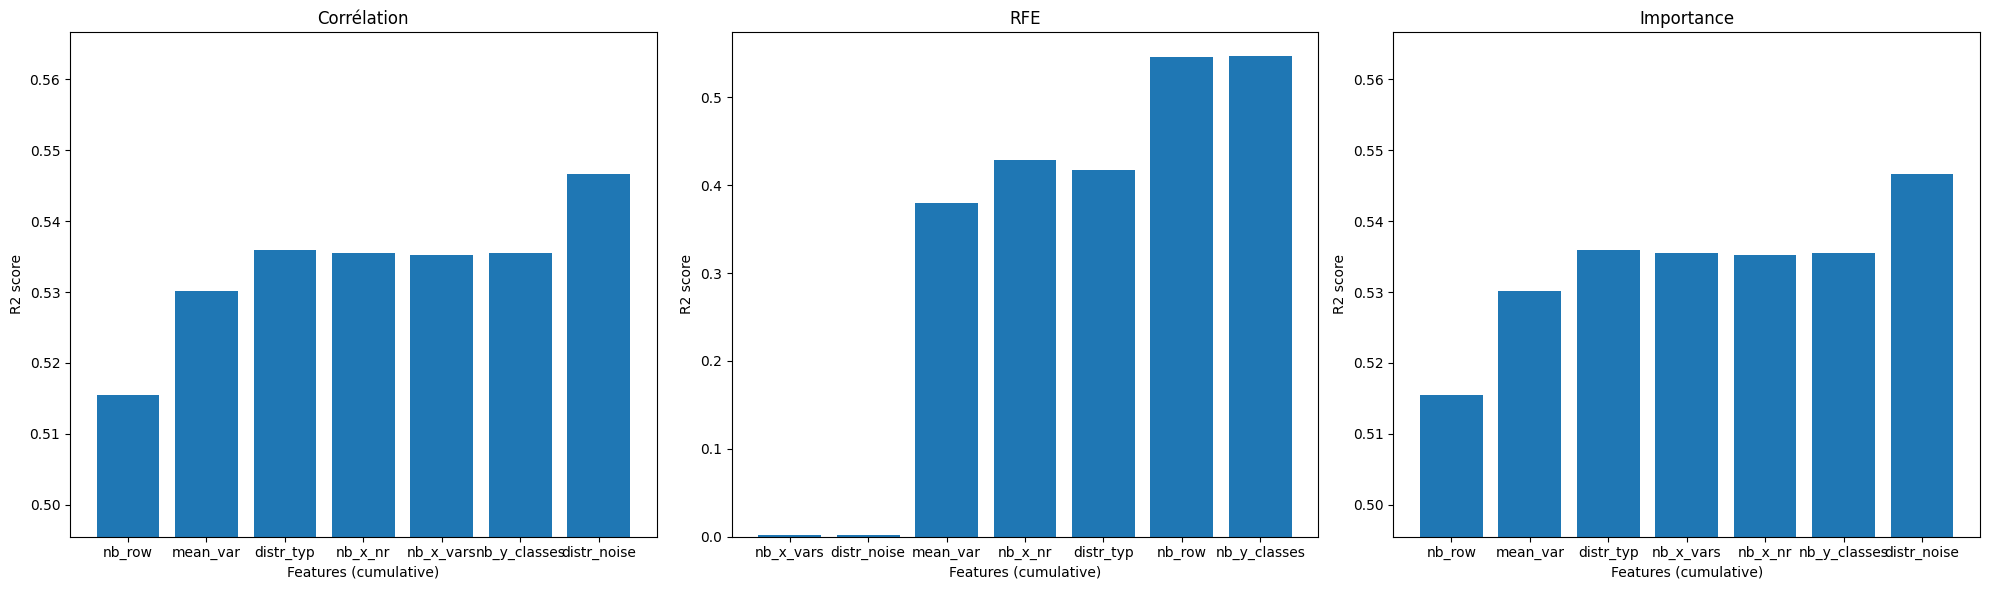

In [8]:
plot_r2(df, "bar")

This feels like repeating the plot vizualisation. Although, we scaled the y-axis for 'corr' and 'importance' and 'distr_typ' and 'distr_noise' do seem to have an impact again. 

More generally though, as we again haven't set a seed for our random generation, the results we obtain vary wildly from test to test, with 'mean_var' becoming a burden at times. 'train_test_split' meets here its limits.